Edited by Mohamed Sayed on 27/11/2019. All errors are now my own.
# Practical 7 - Part 1A

The aim of part 1A is to calculate the homography that best maps two sets of points to one another.  We will (eventually) use this for creating panoramas, and for calculating the 3D pose of planes.  You should use this
template for your code and fill in the missing sections marked "TO DO"


## Import libraries 

In [50]:
%matplotlib inline
import os 
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio

## Test case formulation

To start with, let's set up some start points `pts1Cart` and a homography, `H`, that we can use to generate target points `pts2Cart`. We'll also add some noise to `pts2Cart` to simulate a real world environment. The challenge is to find the same homography, or as close as noise allows, given `pts1Cart` and `pts2Cart`.

__NOTE:__ It may be helpful to set `noiseLevel` to 0 to start with so that you can check if your solution is spot on while debugging. Make sure you set it back to some value, here we use 4, when you're confident your solution works.

In [51]:
# Define a set of two-dimensional Cartesian points
pts1Cart = np.array([[240.5000, 16.8351, 33.5890, 164.2696, 149.1911],
                    [248.8770, 193.5890, 251.3901, 168.4581, 228.7723]]) # 5 2-D Cartesian points in the form [x,y]

# Convert points into homogeneous representation
pts1Hom = np.concatenate((pts1Cart, np.ones((1,pts1Cart.shape[1]))), axis=0) # From [x,y] to [x,y,1]

# Define a homography
H = np.array([[0.6, 0.7, -100.],
              [1.0, 0.6, 50.],
              [0.001, 0.002, 1.0]]) # p2 = H*p1

# Apply a homography to the points
pts2Hom = np.matmul(H,pts1Hom) # output a 3x5 matrix of transformed points in homogeneous coordinates

# Convert back to Cartesian coordinates
pts2Cart = pts2Hom[0:2,:] / np.tile([pts2Hom[2,:]],(2,1)) 

# Add a small amount of noise. Set this to zero to begin with to see if your homography solution is spot on.
noiseLevel = 20
pts2Cart = pts2Cart + np.random.normal(0, noiseLevel, pts2Cart.shape)

# Start with a set of known 2D points (pts1Cart)
# Transform them using a known homography matrix (H)
# Add Gaussian noise to the transformed points (pts2Cart) 

## Plotting

Let's plot the the first original set of points, `pts1Cart`, in blue and the second set of points, `pts2Cart`, in red. 

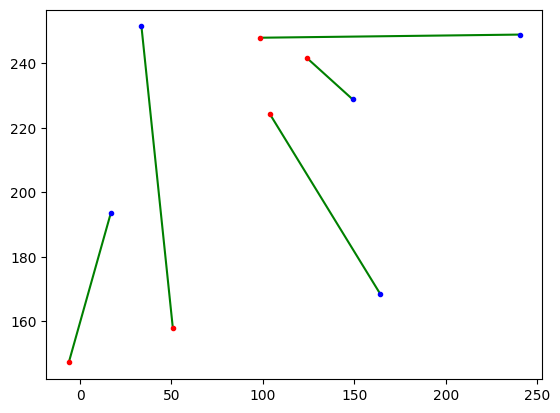

In [52]:
# Plot a green line between pairs of start points (blue) and transformed points (red).|
nPoint = pts1Cart.shape[1]
for cPoint in range(0, nPoint):
    plt.plot([pts1Cart[0,cPoint], pts2Cart[0,cPoint]], [pts1Cart[1,cPoint], pts2Cart[1,cPoint]],'g-')
    plt.plot(pts1Cart[0,cPoint],pts1Cart[1,cPoint],'b.', pts2Cart[0,cPoint],pts2Cart[1,cPoint],'r.') 

plt.show()

**Figure Comment**:  
- Green lines connect each original points (blue) to its transformed counterpart (red), showing the displacement caused by the homography.
- One pros is that the visualization effectively illustrates how the homography matrix transforms the points, and the noise impact is visible.

## Homography estimation time!

We've formulated our test example; now our goal is to estimate the homography that maps the first set of points to the second set of points.

### ****TO DO****: Fill in the details of these routines (solveAXEqualsZero and calcBestHomography). 

In [53]:
def solveAXEqualsZero(A):
    # TO DO: Write this routine - it should solve Ah = 0. You can do this using SVD. Consult your notes! 
    # Hint: SVD will be involved. 
    
    """
    Solves the equation A * h = 0 using Singular Value Decomposition (SVD).
    
    Input:
        A (numpy.ndarray): The input matrix A of size (m, n).
    
    Returns:
        h (numpy.ndarray): The solution vector h (the last column of V from SVD).
    """
    # Perform SVD on A
    U, S, Vt = np.linalg.svd(A)
    
    # The solution to A * h = 0 is the singular vector corresponding to the smallest singular value
    h = Vt[-1, :] # The last row of Vt (V transposed) corresponds to the smallest singular value
    
    return h

# A is a matrix of points in one image (either 2D or 3D, as a list of homogeneous coordinates)
# h is the 1 x 9 vectorized form of the homography matrix
# H is the 3 x 3 homography matrix

In [54]:
def calcBestHomography(pts1Cart, pts2Cart):
    
    # This function should apply the direct linear transform (DLT) algorithm to calculate the best 
    # homography that maps the cartesian points in pts1Cart to their corresonding matching cartesian poitns 
    # in pts2Cart.
    
    # This function calls solveAXEqualsZero. Make sure you are wary of how to reshape h into a 3 by 3 matrix. 
    """
    Calculates the best homography matrix H that maps the Cartesian points 
    in pts1Cart to their corresponding points in pts2Cart using the DLT algorithm.
    
    Parameters:
        pts1Cart (numpy.ndarray): Source Cartesian points of size (2, n_points).
        pts2Cart (numpy.ndarray): Destination Cartesian points of size (2, n_points).
    
    Returns:
        H (numpy.ndarray): The 3x3 homography matrix.
    """
    n_points = pts1Cart.shape[1]
    
    # TODO: replace this:
    
    # TODO: 
    # First convert points into homogeneous representation
    # Hint: we've done this before  in the skeleton code we provide.
    pts1Hom = np.concatenate((pts1Cart, np.ones((1, n_points))), axis=0) # add a row of ones
    pts2Hom = np.concatenate((pts2Cart, np.ones((1, n_points))), axis=0) 
    
    # TODO: 
    # Then construct the matrix A, size (n_points * 2, 9)
    # Consult the notes!
    # Initialize the A matrix
    A = []
    for i in range(n_points):
        x, y, w = pts1Hom[:, i] # source points in homogeneous coordinates
        x_prime, y_prime, w_prime = pts2Hom[:, i] # destination points in homogeneous coordinates
        
        # Construct two rows for the corresponding points (x,y) -> (x',y')
        A.append([0, 0, 0, x, y, w, -y_prime*x, -y_prime*y, -y_prime])
        A.append([x, y, w, 0, 0, 0, -x_prime*x, -x_prime*y, -x_prime])
        
        
    A = np.array(A)
    # TODO: 
    # Solve Ah = 0 using solveAXEqualsZero and get h.
    h = solveAXEqualsZero(A)
    
    # TODO: 
    # Reshape h into the matrix H, values of h go first into rows of H
    H = np.reshape(h, (3, 3))

    return H

## Test time!

Time to put it all together. 

Now we need a way of measuring how well our mapping does. To do this we will apply our estimated mapping, `HEst`, to `pts1Cart` and obtain estimated points `pts2EstCart`. We will compare `pts2EstCart` and `pts2Cart` using a sum of squared difference to see how well our solution at least approximates the transformed noisy points `pts2Cart`.

Red points on the plot are the noisy points we observe, `pts2Cart`, and the magenta points are the transformed points, `pts2EstCart`, that we get when we apply our estimated homography on `pts1Cart`. The black lines represent the error between both points; if you've set `noiseLevel` to 0, then `sqDiff` should be 0 and the points should overlap perfectly.

Sqaured difference between pts2Cart and pts2EstCart is: 314.04


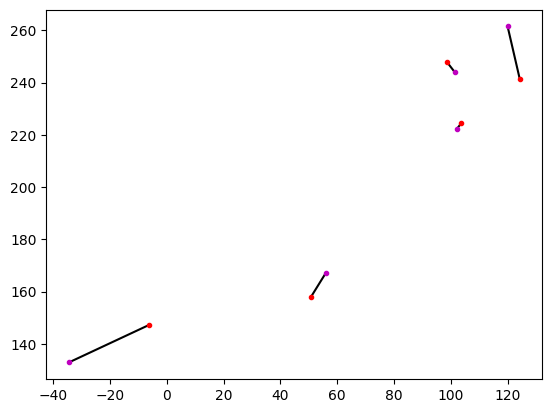

In [55]:
# Replace this with a call to the function calcBestHomography. You'll need to figure out which way around the 
# points go in the function, i.e. which direction this homography transforms points from and to. The ordering 
# is dead simple for now but acts as a simple exercise for what comes in later parts of this practical.
# TODO: 
HEst = calcBestHomography(pts1Cart, pts2Cart) # Calculate homography using our last function 

# Apply estimated homography to points
pts2EstHom = np.matmul(HEst,pts1Hom)

# Convert back to Cartesian coordinates
pts2EstCart = pts2EstHom[0:2,:] / np.tile([pts2EstHom[2,:]],(2,1))

# Calculate the mean squared distance from actual points
sqDiff = np.mean(sum((pts2Cart - pts2EstCart)**2))

print("Sqaured difference between pts2Cart and pts2EstCart is: %.2f" % sqDiff)

# Draw figure with points before and after applying the estimated homography
nPoint = pts1Cart.shape[1]

# Plot a black line between pairs of actual points (red) and estimated points (magenta)
for cPoint in range(0, nPoint):
    plt.plot([pts2Cart[0,cPoint], pts2EstCart[0,cPoint]], [pts2Cart[1,cPoint], pts2EstCart[1,cPoint]],'k-')
    plt.plot(pts2Cart[0,cPoint],pts2Cart[1,cPoint],'r.',pts2EstCart[0,cPoint],pts2EstCart[1,cPoint],'m.') 

plt.show()

**Figure Comment**:  
- The plot shows red (actual) and magenta (estimated) points connected by short black lines, indicating relatively small but noticeable errors between the actual and estimated positions (315.04 squared difference). 
- The short length of the lines suggests the homography estimation performs well, but slight discrepancies still remain. 
- A key advantage of this figure is the clear visualization of error, while a limitation is that small errors could accumulate if more points or higher noise levels are introduced. (currently noise = 20)



## Other things **** TO DO ****

1: Convince yourself that the homography is ambiguous up to scale (by
multiplying it by a constant factor and showing it does the same thing).
Can you see why this is the case mathematically?

2: Show empirically that your homography routine can EXACTLY map any four points to any
other four points.

*1. Scale Ambiguity*
- We scale the homography matrix `HEst` by `k`.
- When applying `k` `H` to the points, the resulting Cartesian coordinates remain unchanged.
- The output difference is shown to be very close to zero, confirming the scale ambiguity.

In [56]:
# Scale the homography matrix by a constant factor
k = 2
HEstScaled = HEst * k

# Apply scaled estimated homography to original points
pts2EstHomScaled = np.matmul(HEstScaled,pts1Hom)

# Convert back to Cartesian coordinates
pts2EstCartScaled = pts2EstHomScaled[0:2,:] / np.tile([pts2EstHomScaled[2,:]],(2,1))

# Verify if equivalent with the original homography
print("Difference between pts2EstCart and pts2EstCartScaled:")
print(np.abs(pts2EstCart - pts2EstCartScaled))



Difference between pts2EstCart and pts2EstCartScaled:
[[0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]]


*2. Exact Mapping of Four Points*

In [57]:
# Define any 4 source points (pts1Cart) and 4 destination points (pts2Cart)
pts1Cart = np.array(
    [[0, 1, 0, 1],
    [0, 0, 1, 1]])  # Square corners

pts2Cart = np.array([[50, 150, 50, 150],
                    [50, 50, 150, 150]])  # A bit bigger square

# Convert to homogeneous coordinates
pts1Hom = np.concatenate((pts1Cart, np.ones((1, pts1Cart.shape[1]))), axis=0)
pts2Hom = np.concatenate((pts2Cart, np.ones((1, pts2Cart.shape[1]))), axis=0)

# Calculate the homography
HEst = calcBestHomography(pts1Cart, pts2Cart)

# Apply the estimated homography to the original points
pts2EstHom = np.matmul(HEst, pts1Hom)

# Convert back to Cartesian coordinates
pts2EstCart = pts2EstHom[0:2, :] / np.tile([pts2EstHom[2, :]], (2, 1))

# Print the estimated homography
print("Original destination points (pts2Cart):")
print(pts2Cart)
print("Estimated destination points (pts2EstCart):")
print(pts2EstCart)

# Verify the exact mapping
print("Difference between pts2Cart and pts2EstCart:")
print(np.abs(pts2Cart - pts2EstCart))

Original destination points (pts2Cart):
[[ 50 150  50 150]
 [ 50  50 150 150]]
Estimated destination points (pts2EstCart):
[[ 50. 150.  50. 150.]
 [ 50.  50. 150. 150.]]
Difference between pts2Cart and pts2EstCart:
[[3.05533376e-13 6.53699317e-13 3.05533376e-13 7.38964445e-13]
 [7.95807864e-13 9.94759830e-14 1.42108547e-13 1.13686838e-13]]


- The code demonstrates that the homography matrix `H` can exactly map four source points to their corresponding destination points. The source points (`pts1Cart`) form a square, and the destination points (`pts2Cart`) represent a scaled and shifted version of the square. 
- The calculated homography matrix `HEst` successfully transforms the source points to their exact destination counterparts. The numerical difference between the actual destination points and the estimated points is near zero, confirming the correctness of the homography estimation.